# Reduction of magnetic data to the pole

This code uses the potential-field data computed in the notebook `aula_7c_dados_sinteticos_mag.ipynb`.

### Things we have to import

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [4]:
import time

In [5]:
import pickle

In [6]:
from gravmag import data_structures, utils, aux_vedo, constants, check, transforms, inverse_distance, convolve, filters, eqlayer
from gravmag.models import rectangular_prism as rp
from gravmag import plot_functions as plf

In [7]:
import vedo

In [8]:
# set the backend for vedo
vedo.settings.default_backend= 'vtk'
#vedo.settings.default_backend= '2d'

In [9]:
def model_cut(model, pmin, pmax):
    check.are_rectangular_prisms(model)
    check.is_integer(x=pmin, positive=True, include_zero=True)
    check.is_integer(x=pmax, positive=True, include_zero=True)
    if pmin >= pmax:
        raise ValueError('pmin must be greater than pmax')
    nprisms = model['x1'].size
    if pmin >= nprisms:
        raise ValueError('pmin must be smaller than num. of model prisms')
    if pmax >= nprisms:
        raise ValueError('pmax must be smaller than num. of model prisms')
    selected_model = dict()
    for element in model.keys():
        selected_model[element] = model[element][pmin:pmax+1]
    return selected_model

### Load the model

In [10]:
model = pickle.load(open('aula_7c/synthetic_bodies_mag.pickle', 'rb'))

In [11]:
# model properties
print("(xmin, xmax) = ({:.3f}, {:.3f}) m".format(model['prisms']['x1'].min(), model['prisms']['x2'].max()))
print("(ymin, ymax) = ({:.3f}, {:.3f}) m".format(model['prisms']['y1'].min(), model['prisms']['y2'].max()))
print("(top min, top max) = ({:.3f}, {:.3f}) m".format(model['prisms']['z1'].min(), model['prisms']['z1'].max()))
print("(bottom min, bottom max) = ({:.3f}, {:.3f}) m".format(model['prisms']['z2'].min(), model['prisms']['z2'].max()))
print("number of prisms: {}".format(model['prisms']['x1'].size))

(xmin, xmax) = (-5175.187, 4975.835) m
(ymin, ymax) = (-3901.850, 6301.370) m
(top min, top max) = (0.000, 1000.000) m
(bottom min, bottom max) = (120.038, 1500.000) m
number of prisms: 305


In [12]:
# Inclination and declination of model total-magnetization vector
I = model['mag-inclinations'][0]
D = model['mag-declinations'][0]

In [13]:
print(f"Total magnetization inclination {I:.2f}° and declination {D:.2f}°")

Total magnetization inclination -24.20° and declination -45.80°


### Load the data points

In [14]:
data_points = pickle.load(open('aula_7c/data_points.pickle', 'rb'))

In [15]:
data_points['grid']['z']

-100

In [16]:
# number of points along x and y
print('n. data = {}'.format(data_points['shape'][0]*data_points['shape'][1]))

# grid spacing
data_dx, data_dy = data_structures.grid_xy_spacing(area=data_points['area'], shape=data_points['shape'])
print('dx = {:.3f} m | dy = {:.3f} m'.format(data_dx, data_dy))

n. data = 2500
dx = 204.082 m | dy = 204.082 m


In [17]:
X, Y = data_structures.grid_xy_to_full_matrices_view(
    x=data_points['grid']['x'],
    y=data_points['grid']['y'],
    shape=data_points['shape']
)

### Load the true magnetic data

In [18]:
mag_data = pickle.load(open('aula_7c/crustal_field.pickle', 'rb'))

In [19]:
main_field = pickle.load(open('aula_7c/main_field.pickle', 'rb'))

In [20]:
# Median inclination and declination of the main field
I0 = np.median(main_field['I'])
D0 = np.median(main_field['D'])

## Estimate the equivalent layer - classical approach

In [21]:
# set the layer vertical coordinate
z_layer = data_points['grid']['z'] + 4.5*data_dx

In [22]:
# compute the SEDM
R2 = inverse_distance.sedm_BTTB(
    data_grid = data_points['grid'], 
    delta_z = z_layer - data_points['grid']['z'],
    grid_orientation = main_field['grid_orientation']
)

In [23]:
# Compute the vertical gradient of inverse distance function
Tensor = inverse_distance.grad_tensor_BTTB(
    data_grid = data_points['grid'],
    delta_z = z_layer - data_points['grid']['z'],
    SEDM = R2,
    grid_orientation = main_field['grid_orientation'],
    components=['xx', 'xy', 'xz', 'yy', 'yz']
)

In [38]:
F_hat = utils.unit_vector(inc=I0, dec=D0)
h_hat = utils.unit_vector(inc=I0, dec=D0)

In [39]:
a = utils.directional_factors(t=F_hat, u=h_hat)

In [40]:
# compute the eigenvalues matrix
L_Tensor = dict()

for component in ['xx', 'xy', 'xz', 'yy', 'yz']:
    L_Tensor[component] = convolve.eigenvalues_BCCB(BTTB_metadata=Tensor[component])

In [41]:
L = np.zeros_like(L_Tensor['xx'])
for component in ['xx', 'xy', 'xz', 'yy', 'yz']:
    L += a[component]*L_Tensor[component]

In [42]:
# estimate the equivalent layer
convergence, layer = eqlayer.method_iterative_deconvolution_TOB20(
    eigenvalues_matrices=[L],
    data_vectors=[mag_data['tfa']],
    epsilon=1e-7,
    ITMAX=300
)

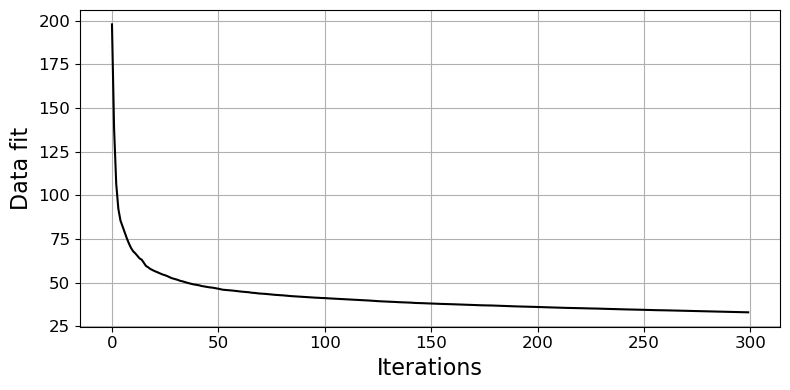

In [43]:
fig, ax = plt.subplots(figsize=(8,4))

iterations = [i for i in range(len(convergence))]
ax.plot(
    iterations, convergence, linestyle='-', c='k', alpha=1, markersize=4
)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xlabel('Iterations', fontsize=16)
ax.set_ylabel('Data fit', fontsize=16)
ax.grid(True)
plt.tight_layout()
plt.show()

## Compute the predicted data

In [44]:
predicted_data = dict()

In [45]:
predicted_data['atfa'] = convolve.product_BCCB_vector(
    eigenvalues = L, ordering = 'row', v = layer
)

## Compute the RTP

In [46]:
predicted_data['rtp'] = convolve.product_BCCB_vector(
    eigenvalues = -(L_Tensor['xx'] + L_Tensor['yy']),
    ordering = 'row',
    v = layer
)

## Plot the results

In [47]:
names = [
    'true tfa', 'predicted tfa eql', 'difference',
    'true rtp', 'predicted rtp eql', 'difference'
]
labels = [
    '(a)', '(b)', '(c)',
    '(d)', '(e)', '(f)'
]

In [48]:
mosaic_elements = [
    'a', 'b', 'c', 
    'd', 'e', 'f'
]

In [49]:
color = 'k'#3*(0.4,)

In [50]:
ranges_data = np.max(np.abs([predicted_data['atfa'], mag_data['tfa']]))
ranges_data_rtp = np.max(np.abs([predicted_data['rtp'], mag_data['rtp']]))

ranges = [
    ranges_data, ranges_data, np.max(np.abs(predicted_data['atfa'] - mag_data['tfa'])),
    ranges_data_rtp, ranges_data_rtp, np.max(np.abs(predicted_data['rtp'] - mag_data['rtp'])),
]

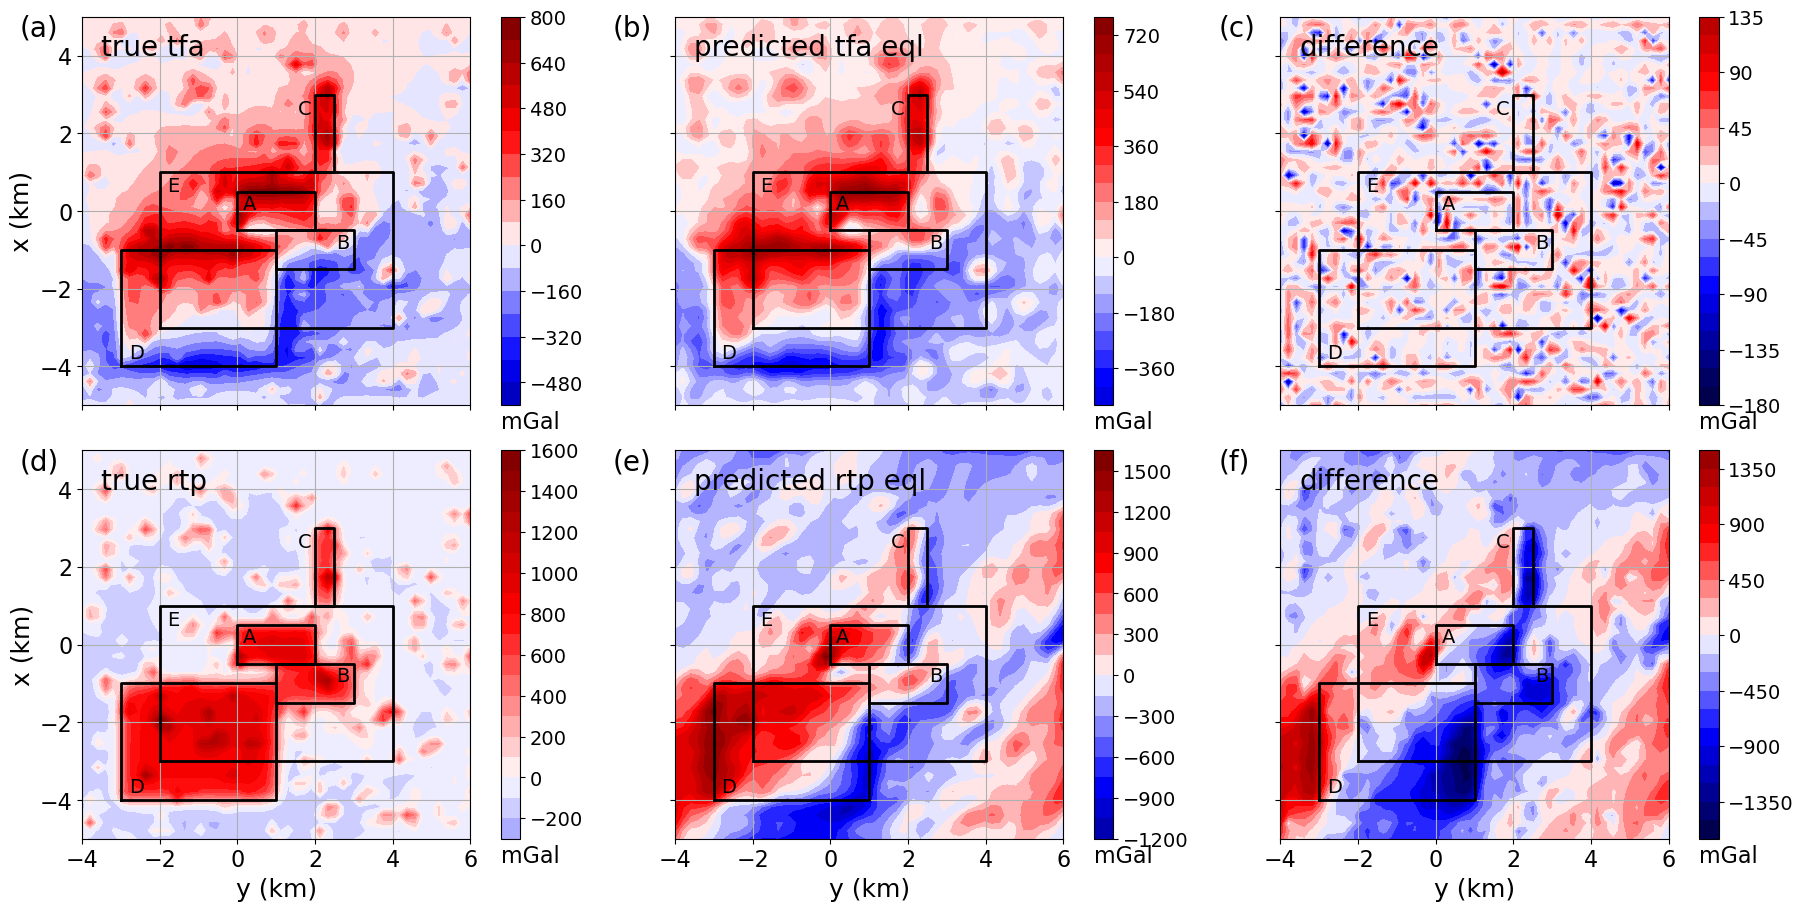

In [51]:
fig = plt.figure(layout= 'constrained', figsize=(18,9))
mosaic = fig.subplot_mosaic('''
                            abc
                            def
                            ''', sharex=True, sharey=True)

for (element, field, name, label, ranges_field) in zip(
    mosaic_elements, 
    [
        mag_data['tfa'], predicted_data['atfa'], predicted_data['atfa'] - mag_data['tfa'],
        mag_data['rtp'], predicted_data['rtp'], predicted_data['rtp'] - mag_data['rtp']
    ], 
    names, 
    labels,
    ranges
):

    ax = mosaic[element]
    ax.axis('scaled')
    im = ax.contourf(Y*0.001, X*0.001, 
                     data_structures.grid_xy_full_flatten_to_matrix(
                         data=field,
                         grid_orientation=main_field['grid_orientation'],
                         shape=data_points['shape']
                     ), 20, 
                     cmap='seismic', vmin=-ranges_field, vmax=ranges_field)
    cb = fig.colorbar(im, ax=ax)
    cb.ax.tick_params(labelsize=14)
    cb.ax.set_xlabel('mGal', fontsize=16, loc='left')
    ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
    ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid()
    ax.annotate(label, xy=(-0.16, 0.95), xycoords='axes fraction', fontsize=20)
    ax.annotate(name, xy=(0.05, 0.90), xycoords='axes fraction', fontsize=20)
    plf.model_boundaries(
        ax,
        model=model_cut(model['prisms'], pmin=0, pmax=4),
        color=color,
        style='-',
        width='2'
    )
    ax.annotate(text='A', xy=(0.15, 0.05), fontsize=14, color=color)
    ax.annotate(text='B', xy=(2.55, -0.95), fontsize=14, color=color)
    ax.annotate(text='C', xy=(1.55, 2.50), fontsize=14, color=color)
    ax.annotate(text='D', xy=(-2.80, -3.80), fontsize=14, color=color)
    ax.annotate(text='E', xy=(-1.80, 0.50), fontsize=14, color=color)

for element in ['a', 'd']:
    mosaic[element].set_ylabel('x (km)', fontsize=18)

for element in ['d','e','f']:
    mosaic[element].set_xlabel('y (km)', fontsize=18)

plt.savefig('aula_10a/eql_classical.png', dpi=300)

plt.show()